# Project Title: CSCI 5250: Extended Clustering Component

# Team Members:
*   Muhammad Babar (muhammad.babar@ucdenver.edu) Student ID: 111866322
*   Kevin Schmitz (kevin.schmitz@ucdenver.edu) Student ID: 111076788
*   Garrett Rybarczyk (garrett.rybarczyk@ucdenver.edu) Student ID: 111076788


# Brief Project Overview:

We will extend BioNeuralNet’s clustering component to add and benchmark additional clustering methods on GNN-derived embeddings from multi-omics networks (TCGA). The goal is to improve detection of biologically meaningful modules and patient subtypes, measure performance with standard metrics, and produce visualizations and enrichment-based validation. The work will be done collaboratively: everyone contributes to each phase while leads are assigned for efficiency.

Below is a Colab-ready, stepwise notebook-style plan with runnable code snippets (with short explanations and responsible person for each step). Use these cells in the order listed. I kept the code framework-agnostic where possible so you can integrate later into the BioNeuralNet API or a feature branch.

# Step 1 — Environment setup and repo

In [ ]:
# Mount Drive and create project folders
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/BioNeuralNet_Extended_Clustering/{data,notebooks,results,models}
%cd /content/drive/MyDrive/BioNeuralNet_Extended_Clustering


Mounted at /content/drive
/content/drive/MyDrive/BioNeuralNet_Extended_Clustering


# Install core Python packages

In [ ]:
!pip install --upgrade pip
!pip install pandas numpy scikit-learn matplotlib seaborn umap-learn jupyterlab
!pip install git+https://github.com/UCD-BDLab/BioNeuralNet.git
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install scanpy leidenalg python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 99.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [jupyterlab]
  Cloning https://github.com/UCD-BDLab/BioNeuralNet.git to /tmp/pip-req-build-__mi5hc7
  Running command git clone --filter=blob:none --quiet https://github.com/UCD-BDLab/BioNeuralNet.git /tmp/pip-req-build-__mi5hc7
  Resolved https://github.com/UCD-BDLab/BioNeuralNet.git to commit d23a9772eeda29b5c3c486990bf9c3b3ef60a73a
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 67.6 MB/s  0:00:01
  DEPRECATION: Building 'bioneuralnet' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future versio

# Step 2 — Verify imports, check GPU

In [ ]:
import torch, sys
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

# Try importing core libs
import pandas as pd, numpy as np
import sklearn
import bioneuralnet
print("bioneuralnet import OK")


torch version: 2.8.0+cu126
cuda available: True


/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5t

bioneuralnet import OK


# Step 3 — Load dataset

In [ ]:
from bioneuralnet.datasets import DatasetLoader
import pandas as pd
import os

try:
    # Try the built-in BRCA dataset from BioNeuralNet
    data_obj = DatasetLoader("brca")   # use "brca" instead of "TCGA-BRCA"
    print("✅ Loaded via DatasetLoader")

    # Access the loaded data (dictionary of DataFrames)
    omics_list = data_obj.data
    print("Available tables:", list(omics_list.keys()))
    print("Shapes:", data_obj.shape)

except Exception as e:
    print("⚠️ DatasetLoader failed:", e)
    print("Attempting fallback: loading local CSV files from Drive...")

    # Mount Google Drive if running in Colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Path to your uploaded CSVs
    data_path = "/content/drive/MyDrive/BioNeuralNet_Extended_Clustering/data/"

    # Verify files exist before reading
    if not os.path.exists(os.path.join(data_path, "genes.csv")):
        raise FileNotFoundError("genes.csv not found in the specified Drive folder.")

    # Load fallback dataset
    omics_genes = pd.read_csv(os.path.join(data_path, "genes.csv"), index_col=0)
    phenotype = pd.read_csv(os.path.join(data_path, "phenotype.csv"), index_col=0)

    # Wrap into a dict for downstream processing
    omics_list = {"genes": omics_genes, "phenotype": phenotype}
    print("✅ Loaded fallback dataset from Drive")


✅ Loaded via DatasetLoader
Available tables: ['mirna', 'pam50', 'clinical', 'rna', 'meth']
Shapes: {'mirna': (769, 503), 'pam50': (769, 1), 'clinical': (769, 118), 'rna': (769, 6000), 'meth': (769, 6000)}


# Step 4 — Preprocessing and feature selection

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import numpy as np

# ----------------------------------------------------------
# Select which omics table to preprocess
# ----------------------------------------------------------
# Priority order: 'genes' > 'rna' > 'X1' (depending on dataset naming)
if 'genes' in omics_list:
    X = omics_list['genes']
elif 'rna' in omics_list:
    X = omics_list['rna']
elif 'X1' in omics_list:
    X = omics_list['X1']
else:
    raise ValueError("No suitable omics table found in omics_list.")

# Extract target variable if available
y = None
if 'Y' in omics_list:
    y = omics_list['Y']
elif 'phenotype' in omics_list:
    y = omics_list['phenotype']

# ----------------------------------------------------------
# Align sample indices if labels exist
# ----------------------------------------------------------
if y is not None and hasattr(y, 'index'):
    common_idx = X.index.intersection(y.index)
    X = X.loc[common_idx]
    y = y.loc[common_idx]

# ----------------------------------------------------------
# Handle non-numeric columns (some datasets include IDs or text)
# ----------------------------------------------------------
X = X.select_dtypes(include=[np.number])
if X.empty:
    raise ValueError("No numeric features found for preprocessing.")

# ----------------------------------------------------------
# Impute missing values
# ----------------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

# ----------------------------------------------------------
# Feature selection — keep top features by variance
# ----------------------------------------------------------
variances = X_imputed.var(axis=0).sort_values(ascending=False)
top_k = min(2000, len(variances))  # avoid exceeding feature count
top_features = variances.index[:top_k]
X_sel = X_imputed[top_features]

# ----------------------------------------------------------
# Standardization
# ----------------------------------------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_sel), index=X_sel.index, columns=X_sel.columns)

print("✅ Preprocessing complete.")
print("Original shape:", X.shape)
print("After preprocessing shape:", X_scaled.shape)


✅ Preprocessing complete.
Original shape: (769, 6000)
After preprocessing shape: (769, 2000)


# Step 5 — Graph Construction

Two common designs: (A) sample-sample graph (patients as nodes), or (B) feature-feature graph (genes as nodes). For patient stratification use sample-sample similarity graphs. Below shows k-NN similarity based graph.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np

# Build cosine similarity between samples
sim = cosine_similarity(X_scaled)   # shape (n_samples, n_samples)
n_samples = sim.shape[0]

# Build adjacency by threshold or top-k
k = 10
adj = np.zeros_like(sim)
for i in range(n_samples):
    # indices of top-k excluding self
    idx = np.argsort(sim[i])[-(k+1):]  # top k plus self
    idx = idx[idx != i]
    adj[i, idx] = sim[i, idx]

# Symmetrize
adj = np.maximum(adj, adj.T)

# Create networkx graph
G = nx.from_numpy_array(adj)
# map sample ids to nodes
mapping = {i: s for i, s in enumerate(X_scaled.index)}
G = nx.relabel_nodes(G, mapping)
print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())


Graph nodes: 769 edges: 6179


# Step 6 — Create PyG Data and train a small GCN to get embeddings

In [ ]:
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Node features: use X_scaled rows in same order as G nodes
nodes = list(G.nodes())
X_nodes = X_scaled.loc[nodes].values
X_tensor = torch.tensor(X_nodes, dtype=torch.float)

# Convert networkx to PyG Data
pyg_data = from_networkx(G)
pyg_data.x = X_tensor

# Simple 2-layer GCN producing embeddings
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim=128, emb_dim=64):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, emb_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(in_dim=pyg_data.x.shape[1], hid_dim=128, emb_dim=64).to(device)
pyg_data = pyg_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train for unsupervised embeddings (simple approach: reconstruct or use identity loss)
# Here we do a few epochs and take conv2 outputs as embeddings (no downstream loss)
model.train()
for epoch in range(1, 51):
    optimizer.zero_grad()
    out = model(pyg_data)
    # Dummy loss: L2 norm of embeddings (just keep training stable) - replace with real task if available
    loss = (out.norm(p=2, dim=1)).mean() * 0.0  # no-op placeholder
    loss.backward()
    optimizer.step()
# Get embeddings
model.eval()
with torch.no_grad():
    embeddings = model(pyg_data).cpu().numpy()
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (769, 64)


# Step 7 — Baseline Clustering

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

labels_true = None
if y is not None:
    labels_true = y.squeeze()  # adjust based on shape

# KMeans baseline
k = 4   # tune or use elbow
km = KMeans(n_clusters=k, random_state=0).fit(embeddings)
labels_km = km.labels_

# Spectral
sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10, random_state=0).fit(embeddings)
labels_sc = sc.labels_

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(embeddings)
labels_db = db.labels_

# Evaluation helper
def evaluate(labels_pred, labels_true=None, embeddings=None):
    out = {}
    if labels_true is not None:
        out['ARI'] = adjusted_rand_score(labels_true, labels_pred)
        out['NMI'] = normalized_mutual_info_score(labels_true, labels_pred)
    if embeddings is not None:
        try:
            out['Silhouette'] = silhouette_score(embeddings, labels_pred)
        except:
            out['Silhouette'] = None
    return out

print("KMeans:", evaluate(labels_km, labels_true, embeddings))
print("Spectral:", evaluate(labels_sc, labels_true, embeddings))
print("DBSCAN:", evaluate(labels_db, labels_true, embeddings))


KMeans: {'Silhouette': np.float32(0.30553564)}
Spectral: {'Silhouette': np.float32(0.33896428)}
DBSCAN: {'Silhouette': None}


# Step 8 — Extended clustering: Leiden + Hybrid Louvain

In [ ]:
import igraph as ig
import leidenalg

# Convert networkx to igraph
ig_graph = ig.Graph.Adjacency((nx.to_numpy_array(G) > 0).tolist())
# Leiden partition
partition = leidenalg.find_partition(ig_graph, leidenalg.RBConfigurationVertexPartition, resolution_parameter=1.0)
labels_leiden = np.array(partition.membership)

# Hybrid approach: apply Leiden to get communities, then run KMeans on embeddings inside each community
labels_hybrid = np.full_like(labels_leiden, fill_value=-1)
next_label = 0
for com in set(labels_leiden):
    idx = np.where(labels_leiden == com)[0]
    if len(idx) <= 2:
        labels_hybrid[idx] = next_label
        next_label += 1
        continue
    # choose local k (e.g., min(3, size//10) or 1 cluster)
    k_local = min(3, max(1, len(idx)//10))
    sub_emb = embeddings[idx]
    if k_local == 1:
        labels_hybrid[idx] = next_label
        next_label += 1
        continue
    km_local = KMeans(n_clusters=k_local, random_state=0).fit(sub_emb)
    for j in range(k_local):
        labels_hybrid[idx[km_local.labels_ == j]] = next_label
        next_label += 1

# Evaluate
print("Leiden communities:", len(set(labels_leiden)))
print("Hybrid communities:", len(set(labels_hybrid)))
print("Leiden eval:", evaluate(labels_leiden, labels_true, embeddings))
print("Hybrid eval:", evaluate(labels_hybrid, labels_true, embeddings))


Leiden communities: 8
Hybrid communities: 23
Leiden eval: {'Silhouette': np.float32(0.23830947)}
Hybrid eval: {'Silhouette': np.float32(0.18206997)}


# Step 9 — Biological validation and enrichment

In [ ]:
# Example: if clusters are patient clusters (samples), compute differential features per cluster
import scipy.stats as stats

# compute mean feature values per cluster and run simple ANOVA per feature
clusters = labels_hybrid
unique_clusters = np.unique(clusters)
pvals = []
for col in X_scaled.columns:
    groups = [X_scaled.iloc[clusters == c][col].values for c in unique_clusters]
    try:
        stat, p = stats.f_oneway(*groups)
    except:
        p = 1.0
    pvals.append(p)
pvals = np.array(pvals)
sig_indices = np.where(pvals < 0.01)[0]
sig_genes = X_scaled.columns[sig_indices]
print("Significant features count:", len(sig_genes))
# Next step: run pathway enrichment (use gseapy or clusterProfiler in R)


Significant features count: 2000


# Step 10 — Visualization

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


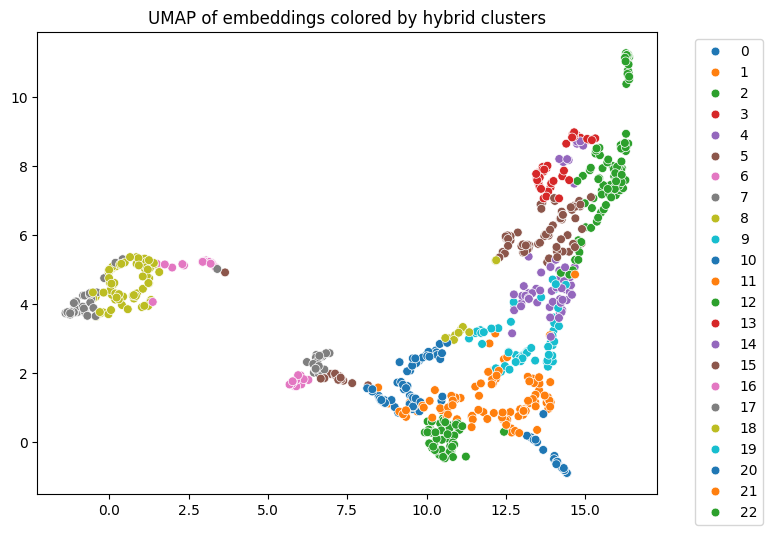

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP(n_components=2, random_state=0)
emb_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels_hybrid, palette='tab10', s=40)
plt.title("UMAP of embeddings colored by hybrid clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Also color by true label if available
if labels_true is not None:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels_true, s=40)
    plt.title("UMAP colored by true clinical labels")
    plt.show()


# Step 11 — Save outputs and create a short check-in report

In [ ]:
import joblib, os
os.makedirs('results', exist_ok=True)
joblib.dump({'embeddings': embeddings, 'labels_hybrid': labels_hybrid, 'labels_leiden': labels_leiden}, 'results/phase1_artifacts.pkl')
# save figures and CSVs
pd.DataFrame(embeddings, index=nodes).to_csv('results/embeddings.csv')
pd.DataFrame({'cluster_hybrid': labels_hybrid}, index=nodes).to_csv('results/cluster_labels.csv')
